In [1]:
import numpy as np
import cov_script as cs
import matplotlib
import matplotlib.pyplot as plt
np.set_printoptions(linewidth=240)
from scipy.interpolate import interp1d
import pyccl as ccl

In [2]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

Get the correlation matrix of Ups_gm, Ups_gg and beta, using Shadab's Cov(Ups_gx, beta) elements estimated from simulations.

First compute and load the covariance matrix from the JN simulations + HOD samples computed by Shadab.

In [3]:
rp0 = 1.6
cov_corr_dict = cs.evaluate_correlation_matrix(stat_list=['gm','gg', 'beta'],rmin=rp0,plots=0,data_dir='')

In [4]:
print(cov_corr_dict['cov'].shape)
# Okay, so we know there are 15 rp bins for Upgg and Upgm, and one value of beta. Beta is at the end (checked)

(31, 31)


In [5]:
rp = np.loadtxt(
    './test-HOD-PB00-z0.75-w1pz_cat-zRSD-model-5-gxm-sel-crossparticles-wtag-w1-rfact10-bin1-wp-logrp-pi-NJN-100.txt.upsilon')[:,0]
print(rp)
ind = next(j[0] for j in enumerate(rp) if j[1]>rp0)
rp_cut = rp[ind:]
print(rp_cut)
print(len(rp_cut))

[ 0.11591284  0.15280288  0.20143342  0.26554097  0.35005117  0.46145732  0.60831922  0.80192091  1.05713764  1.39357881  1.83709466  2.42176242  3.19250463  4.20854074  5.54793718  7.31360558  9.64120984 12.70958983 16.75450244
 22.08673575 29.11598823 38.38234769 50.59778848 66.70087562 87.92887875]
[ 1.83709466  2.42176242  3.19250463  4.20854074  5.54793718  7.31360558  9.64120984 12.70958983 16.75450244 22.08673575 29.11598823 38.38234769 50.59778848 66.70087562 87.92887875]
15


We need to make sure everything is in the same units. I believe that Shadab's Upsilons are in units Mpc/h, whereas mine are in units Msol * h / pc^2. The factor to get them in the same units is rho_crit (in particular units).

In [6]:
mperMpc = 3.0856776*10**22
Msun = 1.989*10**30 # in kg
Gnewt = 6.67408*10**(-11) # kg^{-1}m^3 s^{-2}
c=2.99792458*10**(8) # m / s
rho_crit = 3. * 10**10 * mperMpc / (8. * np.pi * Gnewt * Msun) / 10**12  
# rho crit in Msol h^2 / Mpc / pc^2, to yield Upsilon_gg in Msol h / pc^2

OmegaM = 0.292

rpbins = 15

For Upsilon x beta, we should multiply by a single factor of rho_crit. For Upsilon x Upsilon, two factors.
In the case of Upsilon_gm, the sims stuff also has a missing factor of Omega_M whic we need to add.

Now load my analytical calculation of the covariance matrix (using in part Sukdheep's old Hankel transform code).

In [7]:
cov_Danielle = np.loadtxt('../txtfiles/joint_covariance_rp0exactinterp_Aug23_2024.dat')

In [8]:
print(cov_Danielle.shape)
# Good, it's the same shape.

(31, 31)


Now let's get the simulations covariance matrix in the same units as mine, and also make a combined covariance matrix. Remember to multiply the elements from Shadab by rho_crit to get the right units. We also rescale to account for the difference between the volume that goes into our analytic covariance and the volume of Shadab's sim.

In [9]:
# Get our volume - this is hard-coded and I probably should be calling the function
h=0.69
OmB = 0.022/h**2
params = {'mu_0': 0., 'sigma_0':0., 'OmB':OmB, 'h':h, 'n_s':0.965, 'sigma8':0.82,'b':2.03, 'OmM': 0.292}
cosmo_fid = ccl.Cosmology(Omega_c = params['OmM'] - params['OmB'], Omega_b = params['OmB'], h = params['h'], sigma8=params['sigma8'], n_s = params['n_s'])
area_deg = 5000. # degrees squared; area overlap of DESI with LSST
area_com = area_deg * (np.pi / 180.)**2 * (ccl.comoving_radial_distance(cosmo_fid, 1./ (1. +0.72))*  params['h'] )**2 # Using effective redshift of DESI LRGs
# L_W is the top hat window function over the *lens* galaxies 
L_W=  ((ccl.comoving_radial_distance(cosmo_fid, 1./ (1. +1.0))* params['h'] ) - (ccl.comoving_radial_distance(cosmo_fid, 1./ (1. +0.4))* params['h'] ))
vol=area_com*L_W

In [10]:
print(vol)

6101765357.247895


In [11]:
#us_LSST_DESI_vol = 2515941346 #(Mpc/h)^3
us_LSST_DESI_vol = vol
sims_Lbox = 1380 # Mpc/h
sims_vol = sims_Lbox**3 # (Mpc/h)^3

# Covariance goes like 1/volume, so multiply sims terms by sims_vol / us_vol to go to us_vol

volume_factor = sims_vol / us_LSST_DESI_vol
print(volume_factor)

0.43070682763608437


In [12]:
cov_sims_myunits = np.zeros_like(cov_Danielle)

In [13]:
# Ups_gm x Ups_gg
# Rescale by: volume factor, Omega_M*rho_crit**2 (= rho_M**2)
cov_sims_myunits[0:rpbins,0:rpbins] = rho_crit**2*volume_factor*OmegaM**2*cov_corr_dict['cov'][0:rpbins, 0:rpbins] # gm x gm

# Ups_gm x Ups_gg
# Rescale by: volume_factor, Omega_M*rho_crit (= rho_m), rho_crit
cov_sims_myunits[0:rpbins,rpbins:2*rpbins] = rho_crit**2*volume_factor*OmegaM*cov_corr_dict['cov'][0:rpbins, rpbins:2*rpbins] #gm x gg
cov_sims_myunits[rpbins:2*rpbins,0:rpbins] = rho_crit**2*volume_factor*OmegaM*cov_corr_dict['cov'][rpbins:2*rpbins, 0:rpbins] #gm x gg

# Ups_gg x Ups_gg
# Rescale by: volume_factor, rho_crit^2
cov_sims_myunits[rpbins:2*rpbins, rpbins:2*rpbins] = rho_crit**2*volume_factor*cov_corr_dict['cov'][rpbins:2*rpbins, rpbins:2*rpbins] #gg x gg

# Ups_gm x beta
# Recale by: volume factor, rho_crit*OmegaM
cov_sims_myunits[2*rpbins,0:rpbins] = rho_crit*OmegaM*volume_factor*cov_corr_dict['cov'][2*rpbins, 0:rpbins] # gm x beta
cov_sims_myunits[0:rpbins,2*rpbins] = rho_crit*OmegaM*volume_factor*cov_corr_dict['cov'][0:rpbins,2*rpbins] # gm x beta

# Ups_gg x beta from sims
# Rescale by: volume factor, rho_crit
cov_sims_myunits[2*rpbins,rpbins:2*rpbins] = rho_crit*volume_factor*cov_corr_dict['cov'][2*rpbins, rpbins:2*rpbins] # gg * beta
cov_sims_myunits[rpbins:2*rpbins,2*rpbins] = rho_crit*volume_factor*cov_corr_dict['cov'][rpbins:2*rpbins, 2*rpbins] # gg x beta

# beta x beta
# Rescale by volume factor
cov_sims_myunits[2*rpbins,2*rpbins] = volume_factor*cov_corr_dict['cov'][2*rpbins, 2*rpbins] # beta x beta

In [14]:
# Get the corresponding correlation matrix too:
corr_sims_myunits = np.zeros_like(cov_sims_myunits)
for i in range(0,len(cov_sims_myunits[0,:])):
    for j in range(0,len(cov_sims_myunits[:,0])):
        corr_sims_myunits[i,j] = cov_sims_myunits[i,j] / np.sqrt(cov_sims_myunits[i,i] * cov_sims_myunits[j,j])  

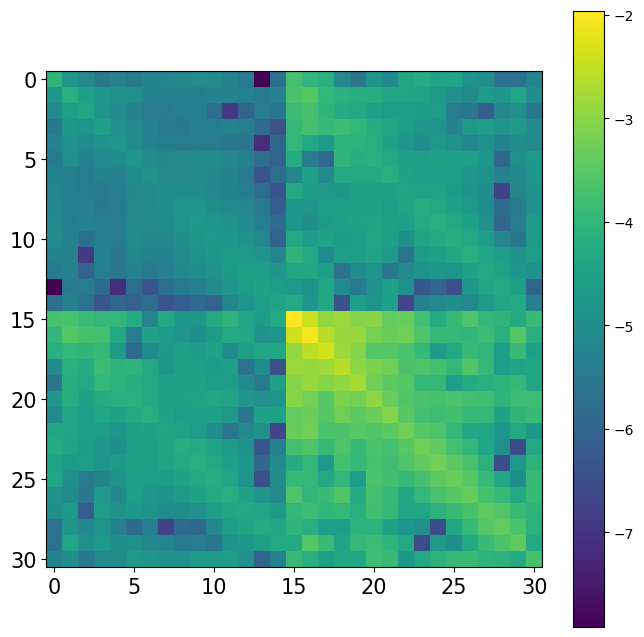

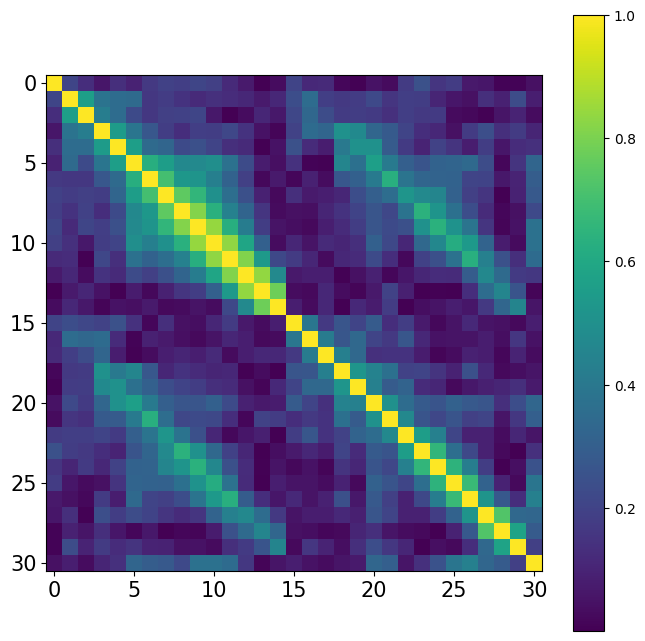

In [15]:
# Visualize the full covariance and correlation matrix - sims

plt.figure(figsize=[8,8])
plt.imshow(np.log10(np.abs(cov_sims_myunits)))
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.colorbar()
plt.savefig('../plots/sims_corr_log10.pdf')
plt.show()

plt.figure(figsize=[8,8])
plt.imshow(np.abs(corr_sims_myunits))
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.colorbar()
plt.savefig('../plots/sims_corr_myunits.pdf')
plt.show()

In [16]:
# Output the simulations covariance in my units in case we need this:

np.savetxt('../txtfiles/sims_cov_myunits_August23_2024.dat', cov_sims_myunits)

In [17]:
check_symmetric(cov_sims_myunits)
eig, eigv = np.linalg.eig(cov_sims_myunits)
print(eig>0)

[ True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True]


In [18]:
# Get the correlation matrix for the analytic covariance too:

# Get the corresponding correlation matrix too:
corr_Danielle = np.zeros_like(cov_Danielle)
for i in range(0,len(cov_Danielle[0,:])):
    for j in range(0,len(cov_Danielle[:,0])):
        corr_Danielle[i,j] = cov_Danielle[i,j] / np.sqrt(cov_Danielle[i,i] * cov_Danielle[j,j]) 

In [19]:
check_symmetric(cov_Danielle)
eig, eigv = np.linalg.eig(cov_Danielle)
print(eig>0)

[ True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True]


/tmp/ipykernel_17368/553507585.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(cov_Danielle)))


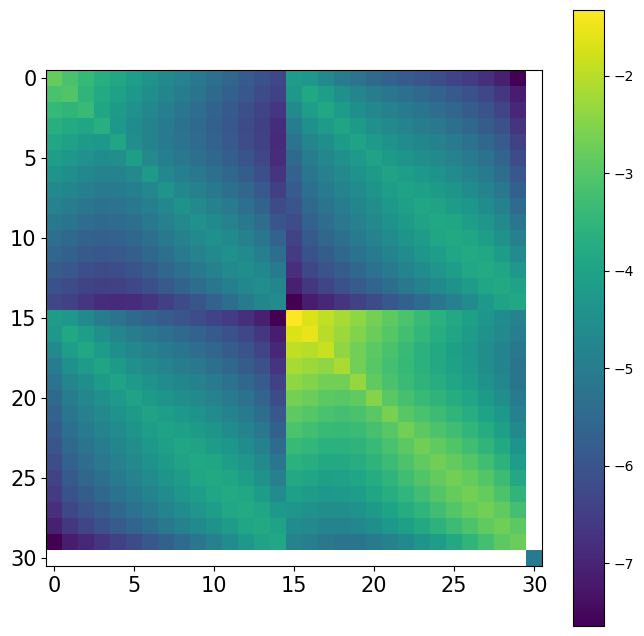

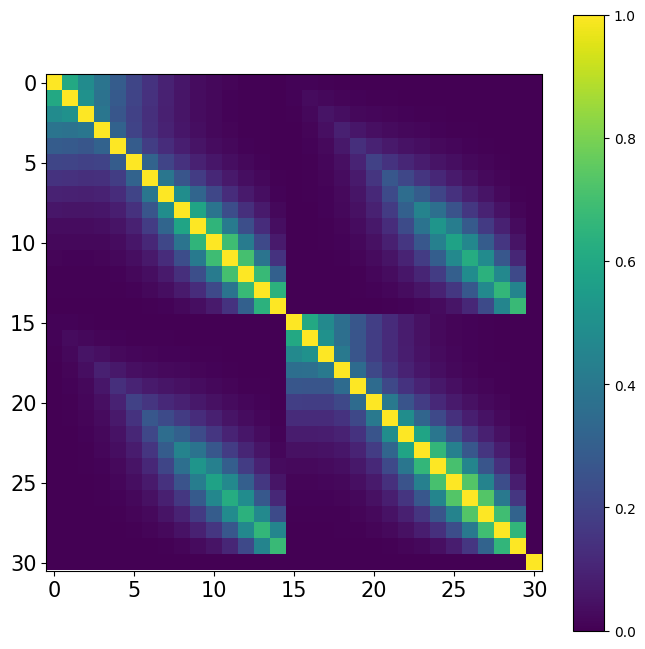

In [20]:
# Visually the covariance and correlation matrix from my analytic code:

plt.figure(figsize=[8,8])
plt.imshow(np.log10(np.abs(cov_Danielle)))
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.colorbar()
plt.savefig('../plots/analytic_cov_log10.pdf')
plt.show()

plt.figure(figsize=[8,8])
plt.imshow(corr_Danielle)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.colorbar()
plt.savefig('../plots/analytic_corr.pdf')
plt.show()

Now we get a hybrid matrix that takes bits from both analytic and simulation methods.

In [21]:
combined_cov = np.zeros_like(cov_Danielle)

In [22]:
# Ups_gm x Ups_gm term, from analytic (especially because the simulation does not have shape noise)
combined_cov[0:rpbins,0:rpbins] = cov_Danielle[0:rpbins,0:rpbins] # gmxgm

# Ups_gm x Ups_gg, from analytic
combined_cov[0:rpbins,rpbins:2*rpbins] = cov_Danielle[0:rpbins,rpbins:2*rpbins]
combined_cov[rpbins:2*rpbins,0:rpbins] = cov_Danielle[rpbins:2*rpbins, 0:rpbins] #gm x gg

# Ups_gg x Ups_gg, from analytic
combined_cov[rpbins:2*rpbins, rpbins:2*rpbins] = cov_Danielle[rpbins:2*rpbins, rpbins:2*rpbins]

# Ups_gm x beta from sims 
combined_cov[2*rpbins,0:rpbins] = cov_sims_myunits[2*rpbins, 0:rpbins] # gm x beta
combined_cov[0:rpbins,2*rpbins] = cov_sims_myunits[0:rpbins,2*rpbins] # gm x beta

# Ups_gg x beta from sims 
combined_cov[2*rpbins,rpbins:2*rpbins] = cov_sims_myunits[2*rpbins, rpbins:2*rpbins] # gg * beta
combined_cov[rpbins:2*rpbins,2*rpbins] = cov_sims_myunits[rpbins:2*rpbins, 2*rpbins] # gg x beta

# beta x beta, from sims
combined_cov[2*rpbins,2*rpbins] = cov_sims_myunits[2*rpbins, 2*rpbins] # beta x beta

In [23]:
print(combined_cov[2*rpbins,2*rpbins])
print(cov_Danielle[2*rpbins,2*rpbins])

0.00019860521035895722
9.162599986364112e-06


In [24]:
# Get the hybrid correlation matrix:

combined_corr = np.zeros_like(combined_cov)
for i in range(0,len(combined_cov[0,:])):
    for j in range(0,len(combined_cov[:,0])):
        combined_corr[i,j] = combined_cov[i,j] / np.sqrt(combined_cov[i,i] * combined_cov[j,j]) 

/tmp/ipykernel_17368/1380615445.py:4: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(combined_cov))
/tmp/ipykernel_17368/1380615445.py:6: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(-combined_cov), cmap=plt.cm.magma)


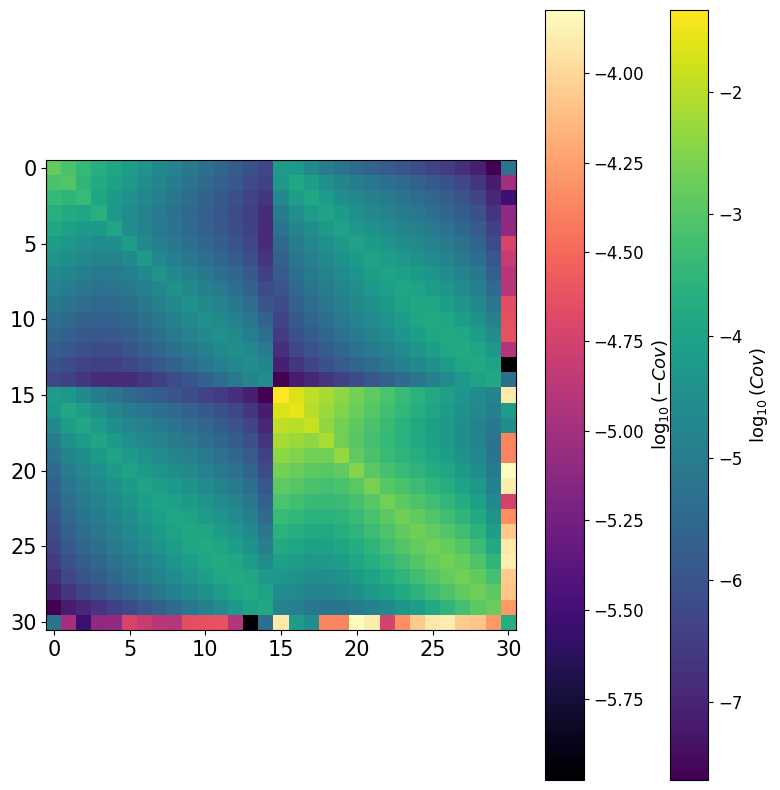

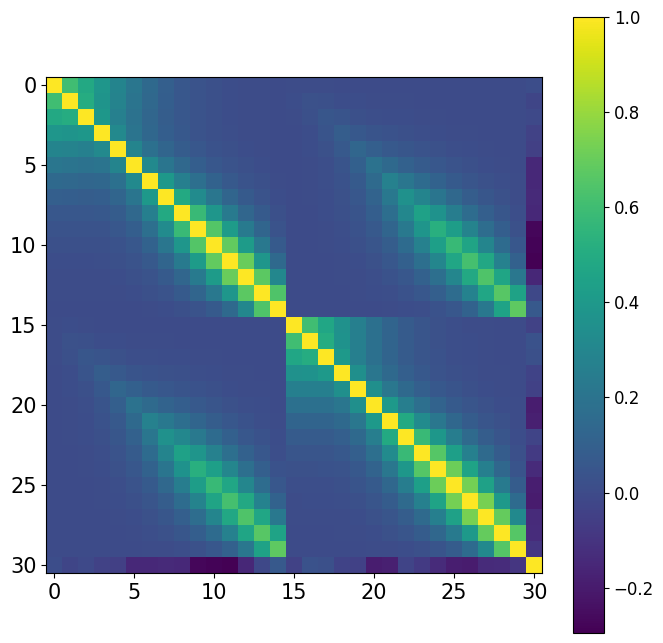

In [33]:
# Visualize the full covariance and correlation matrix- hybrid

plt.figure(figsize=[8,8])
plt.imshow(np.log10(combined_cov))
cbar1=plt.colorbar()
plt.imshow(np.log10(-combined_cov), cmap=plt.cm.magma)
cbar2=plt.colorbar()
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
cbar1.ax.tick_params(labelsize=12)
cbar2.ax.tick_params(labelsize=12)
cbar1.set_label('$\log_{10}(Cov)$', fontsize=13)
cbar2.set_label('$\log_{10}(-Cov)$', fontsize=13)
plt.tight_layout()
plt.savefig('../plots/hybrid_cov_log10.pdf')
plt.show()

plt.figure(figsize=[8,8])
plt.imshow(combined_corr)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
cbar1 = plt.colorbar()
cbar1.ax.tick_params(labelsize=12)
#cbar1.set_label('$Corr$', fontsize=13)
plt.savefig('../plots/hybrid_corr.pdf')
plt.show()

In [34]:
check_symmetric(combined_cov)
eig, eigv = np.linalg.eig(combined_cov)
print(eig>0)

[ True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True]


In [35]:
# Output the hybrid cov for use in calculations:
np.savetxt('../txtfiles/hybrid_joint_cov_August23_2024.dat', combined_cov)

In [31]:
# Just checking no elements are left as zero
print(np.amin(np.abs(combined_cov)))

4.5257795477160504e-09


In [ ]:
# Just print the Upsgx x beta stuff and other stuff to see magnitude

#print("Cov(Ups_gm, beta)=", combined_cov[30,0:15])
#print("Cov(Ups_gm,Upsgm)=", combined_cov[0:15,0:15])

#print("Cov(Ups_gg, beta)=", combined_cov[30,15:30])
#print("Cov(Ups_gg, Ups_gg)=", combined_cov[15:30,15:30])

Let's look numerically at the correlation values for Ups_gm / beta and Ups_gg beta

In [ ]:
# Corr(Ups_gm, beta)
print("Corr(Ups_gm, beta)=", combined_corr[30,0:15])
# Corr(Ups_gg, beta)
print( "Corr(Ups_gg, beta)=", combined_corr[30,15:30])

In [ ]:
rp = np.loadtxt(
    './test-HOD-PB00-z0.75-w1pz_cat-zRSD-model-5-gxm-sel-crossparticles-wtag-w1-rfact10-bin1-wp-logrp-pi-NJN-100.txt.upsilon')[:,0]
print(rp)

In [ ]:
rp_cut = rp[9:]
plt.figure(figsize=[4,4])
plt.loglog(rp_cut, np.abs(combined_cov[2*rpbins, 0:rpbins]), 'o', label="Upgm")
plt.loglog(rp_cut, np.abs(combined_cov[2*rpbins, rpbins:2*rpbins]), 'o', label="Upgg")
plt.xlabel("$r_p$, Mpc/h")
plt.ylabel("corr(Upgx,beta)")
plt.legend()
plt.show()

plt.figure(figsize=[4,4])
plt.loglog(rp_cut,np.abs(combined_corr[2*rpbins, rpbins:2*rpbins]) / np.abs(OmegaM*combined_corr[2*rpbins, 0:rpbins]), 'o', label='Cov(Upgg,beta) / Cov(Upgm,beta)')
plt.ylim(0,10)
plt.xlabel("$r_p$, Mpc/h")
plt.ylabel("corr(Upgg,beta) /corr(Upgm,beta)")
plt.legend()
plt.show()

Okay so, corr(Upsilon_gm, beta) seems to be considerably smaller than corr(Upsilon_gg, beta). That's what we would expect.

Let's look at Shadab's Cov(Ups_gm, Ups_gm) vs mine. Mine should in principle be larger on the diagonal because it includes shape noise.

In [ ]:
# Shadab diagonal Ups_gm, Ups_gm
#print np.diag(cov_corr_dict_gm['cov'][0:15,0:15])
# Mine diagonal Ups_gm, Ups_gm
#print np.diag(combined_cov[0:15,0:15])

plt.figure(figsize=[5,5])
plt.loglog(rp_cut, 
         np.diag(combined_cov[0:rpbins,0:rpbins]), 'o',label='analytic')
plt.loglog(rp_cut, (np.diag(cov_sims_myunits[0:rpbins,0:rpbins])), 'o',label='sims')
plt.ylabel("cov($Upsilon_{gm}$) ratio")
plt.xlabel("$r_p$, Mpc/h")
plt.legend()
plt.show()

plt.figure(figsize=[5,5])
plt.semilogx(rp_cut, 
         (np.diag(combined_cov[0:rpbins,0:rpbins])) / (np.diag(cov_sims_myunits[0:rpbins,0:rpbins])), 
         'ko')
plt.ylabel("cov($Upsilon_{gm}$) ratio")
plt.xlabel("$r_p$, Mpc/h")
plt.show()

In [ ]:
# How does this look off the diagonal? 
covUpsgm_ratio = combined_cov[0:rpbins,0:rpbins] / (cov_sims_myunits[0:rpbins,0:rpbins])

plt.figure(figsize=[5,5])
plt.title('cov(Upsgm,Upsgm) ratio me / sims')
plt.imshow(covUpsgm_ratio)
plt.colorbar()
plt.show()

In principle, my cov(Upsilon_gg, Upsilon_gg) and Shadab's cov(Upsilon_gg, Upsilon_gg) should agree (modulo noise in the sims and non-Gaussian terms).

In [ ]:
# Shadab diagonal Ups_gg, Ups_gg
#print np.diag(cov_corr_dict_gg['cov'][0:15,0:15])
# Mine diagonal Ups_gm, Ups_gm
#print np.diag(combined_cov[15:30,15:30])

plt.figure(figsize=[5,5])
plt.semilogx(rp_cut, 
         np.sqrt(np.diag(cov_Danielle[rpbins:2*rpbins,rpbins:2*rpbins]) / np.diag(cov_sims_myunits[rpbins:2*rpbins,rpbins:2*rpbins])), 'ko')
plt.ylabel('$cov(Upsilon_{gg}, Upsilon_{gg})$, analytic / sim')
plt.show()

plt.figure(figsize=[5,5])
plt.loglog(rp_cut, 
         np.diag(cov_Danielle[rpbins:2*rpbins,rpbins:2*rpbins]), 'o', label='analytic')
plt.loglog(rp_cut, np.diag(cov_sims_myunits[rpbins:2*rpbins,rpbins:2*rpbins]), 'o', label='simulations')
plt.ylabel("cov($Upsilon_{gg}$,$Upsilon_{gg}$)")
plt.legend()
plt.show()

In [ ]:
# How does this look off the diagonal? 
covUpsgg_ratio = cov_Danielle[rpbins:2*rpbins,rpbins:2*rpbins] / (cov_sims_myunits[rpbins:2*rpbins,rpbins:2*rpbins])
plt.figure()
plt.title('cov(Upsgg,Upsgg) ratio me / sims')
plt.imshow(np.log(covUpsgg_ratio))
plt.colorbar()
plt.show()

In [ ]:
# My cov(beta, beta) is only shot noise whereas Shadab's should be shot noise and cosmic variance
print("Shadab, sigma(beta)=", np.sqrt(cov_sims_myunits[2*rpbins,2*rpbins]))
print("My sigma(beta)=", np.sqrt(cov_Danielle[2*rpbins,2*rpbins]))

Right so my cov(Upsilon_gg, Upsilon_gg) should agree with Shadab's but the error on the diagonal is larger by about 2 (meaning the covariance is off by about 4). What's wrong?

let's also look at the two versions of cov(Upgm,Upgg)

In [ ]:
plt.figure(figsize=[5,5])
plt.semilogx(rp_cut, 
         np.diag(cov_Danielle[rpbins:2*rpbins,0:rpbins]) / np.diag(cov_sims_myunits[rpbins:2*rpbins,0:rpbins]), 'ko')
plt.ylabel('$cov(Upsilon_{gg}, Upsilon_{gm})$, analytic / sim')
plt.show()

plt.figure(figsize=[5,5])
plt.loglog(rp_cut, 
         np.diag(cov_Danielle[rpbins:2*rpbins,0:rpbins]), 'o', label='analytic')
plt.loglog(rp_cut, np.diag(cov_sims_myunits[rpbins:2*rpbins,0:rpbins]), 'o', label='simulations')
plt.ylabel("cov($Upsilon_{gg}$,$Upsilon_{gm}$)")
plt.legend()
plt.show()

In [ ]:
# How does this look off the diagonal? 
covUpsgggm_ratio = cov_Danielle[15:30,0:15] / (cov_sims_myunits[15:30,0:15])
plt.figure()
plt.title('cov(Upsgg,Upsgm) ratio me / sims')
plt.imshow(np.log10(covUpsgggm_ratio))
plt.colorbar()
plt.show()

What's going on with the lowest point in rp being way lowert in the analytic case? Is this to do with the transform from Delta to Upsilon?

Load the Delta Sigma covariances themselves to see if it is there:

In [32]:
cov_DS_gm = np.loadtxt('../txtfiles/cov_DeltaSigma_gm_rp0=rp_edges[0]_Aug21_2024.dat')
#cov_DS_gm_2 = np.loadtxt('../txtfiles/cov_DeltaSigma_gm_debug_v_sims_updatebeta_andparams_rp01p5.dat')
cov_DS_gg = np.loadtxt('../txtfiles/cov_DeltaSigma_gg_rp0=rp_edges[0]_Aug21_2024.dat')
cov_DS_gmgg = np.loadtxt('../txtfiles/cov_DeltaSigma_gmgg_rp0=rp_edges[0]_Aug21_2024.dat')

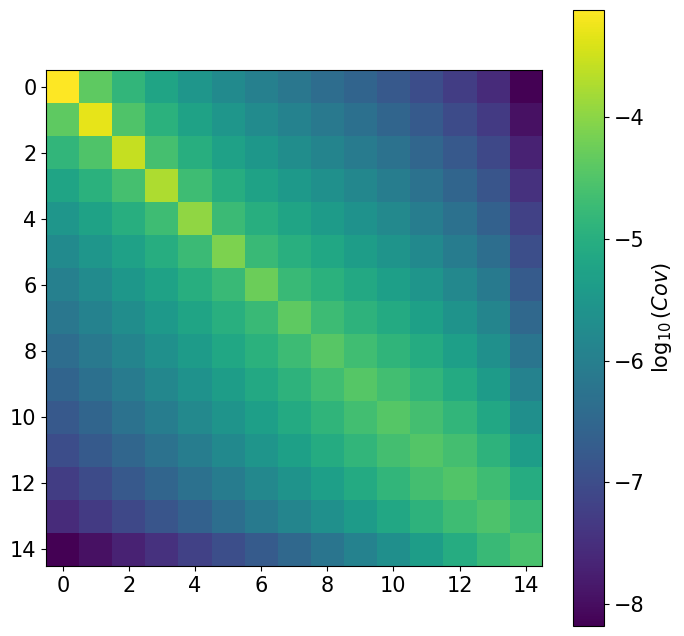

In [34]:
plt.figure(figsize=[8,8])
plt.imshow(np.log10(cov_DS_gm))
cbar1=plt.colorbar()
#plt.imshow(np.log10(-combined_cov), cmap=plt.cm.magma)
#cbar2=plt.colorbar()
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
cbar1.ax.tick_params(labelsize=15)
#cbar2.ax.tick_params(labelsize=15)
cbar1.set_label('$\log_{10}(Cov)$', fontsize=15)
#cbar2.set_label('$\log_{10}(-Cov)$', fontsize=15)
#plt.savefig('../plots/hybrid_cov_log10.pdf')
plt.show()

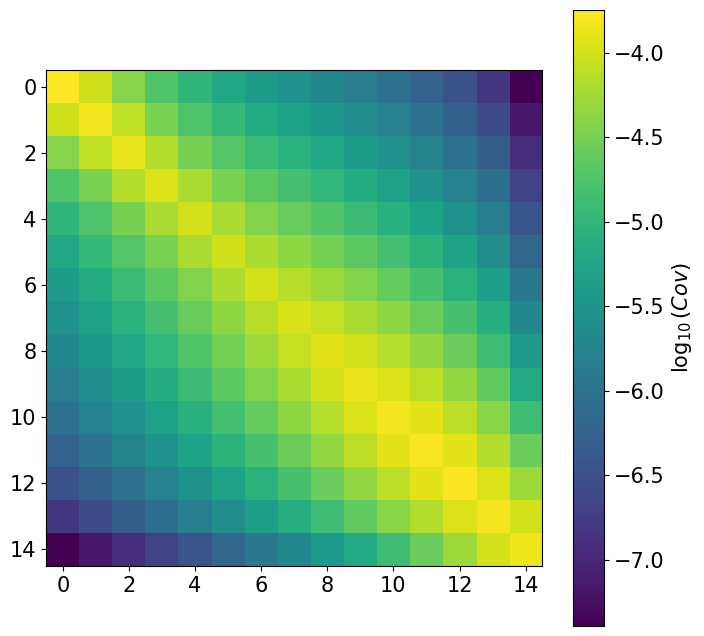

In [36]:
plt.figure(figsize=[8,8])
plt.imshow(np.log10(cov_DS_gmgg))
cbar1=plt.colorbar()
#plt.imshow(np.log10(-combined_cov), cmap=plt.cm.magma)
#cbar2=plt.colorbar()
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
cbar1.ax.tick_params(labelsize=15)
#cbar2.ax.tick_params(labelsize=15)
cbar1.set_label('$\log_{10}(Cov)$', fontsize=15)
#cbar2.set_label('$\log_{10}(-Cov)$', fontsize=15)
#plt.savefig('../plots/hybrid_cov_log10.pdf')
plt.show()

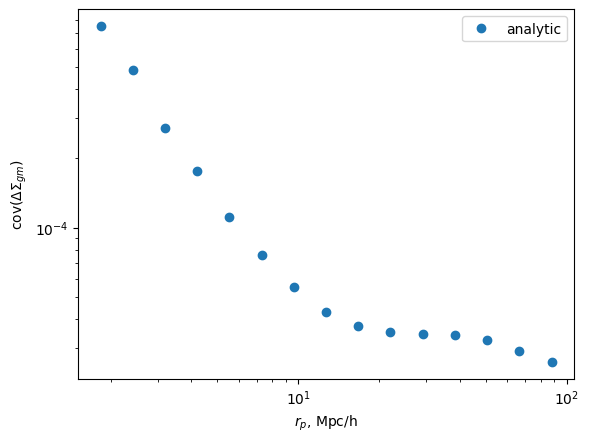

In [33]:
plt.figure()
plt.loglog(rp_cut,
         np.diag(cov_DS_gm), 'o',label='analytic')
#plt.loglog(rp_cut,
#         np.diag(cov_DS_gm_2), 'o',label='analytic')
#plt.loglog(rp_cut, (np.diag(cov_sims_myunits[0:15,0:15])), 'o',label='sims')
plt.ylabel("cov($\Delta \Sigma_{gm}$)")
plt.xlabel("$r_p$, Mpc/h")
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.loglog(rp_cut, 
         np.diag(cov_DS_gg), 'o',label='analytic')
#plt.loglog(rp_cut, (np.diag(cov_sims_myunits[0:15,0:15])), 'o',label='sims')
plt.ylabel("cov($\Delta \Sigma_{gg}$)")
plt.xlabel("$r_p$, Mpc/h")
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.loglog(rp_cut, 
         np.diag(cov_DS_gmgg), 'o',label='analytic')
#plt.loglog(rp_cut, (np.diag(cov_sims_myunits[0:15,0:15])), 'o',label='sims')
plt.ylabel("cov($\Delta \Sigma_{gm}$, $\Delta \Sigma_{gg}$)")
plt.xlabel("$r_p$, Mpc/h")
plt.legend()
plt.show()